In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import tqdm
import pandas as pd
import seaborn as sns

from lib.model import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDatasetAll2All

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
DEVICE = "cpu"

In [5]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True))

<All keys matched successfully>

In [6]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE, time_pairs=time_pairs
    )
)

print("Dataset length:", len(dataset))

Dataset length: 2000


In [7]:
errors = {
    "dt": [],
    "l2_error": [],
    "epsilon": [],
}

In [8]:
BATCH_SIZE = 32
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
fno.eval()
progress_bar = tqdm.tqdm(data_loader)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1)

        for j in range(len(dt)):
            errors["dt"].append(dt[j].item())
            errors["l2_error"].append(loss[j].item())
            errors["epsilon"].append(eps[j].item())

        ood_relative_l2 += loss.sum().item()

    ood_relative_l2 /= len(dataset)

print(rf"OOD relative L2 error: {ood_relative_l2}")

  5%|▍         | 3/63 [00:00<00:02, 27.40it/s]

100%|██████████| 63/63 [00:01<00:00, 42.41it/s]

OOD relative L2 error: 0.22033870816230774


In [ ]:
df = pd.DataFrame(errors)
# sort by dt
df = df.sort_values(by="dt")
df

,dt,l2_error,epsilon
50,0.00125,0.180406,0.005
22,0.00125,0.180406,0.005
1314,0.00125,0.144046,0.005
1313,0.00125,0.180406,0.005
30,0.00125,0.091326,0.005
...,...,...,...
1551,0.20000,0.014367,0.200
1704,0.20000,0.348307,0.200
27,0.20000,0.014367,0.200
23,0.20000,0.348307,0.200


In [11]:
# calculate mean error for each dt
mean_error = df.groupby(pd.cut(df["dt"], bins=20), observed=True)["l2_error"].mean().reset_index()
mean_error["dt"] = mean_error["dt"].apply(lambda x: f"{x.mid:.3f}")
mean_error

,dt,l2_error
0,0.006,0.130240
1,0.016,0.082040
2,0.026,0.081202
3,0.036,0.137103
4,0.046,0.659729
5,0.056,0.078058
6,0.076,0.240840
7,0.096,0.443550
8,0.116,0.270069
9,0.145,0.375156


<Axes: xlabel='dt', ylabel='l2_error'>

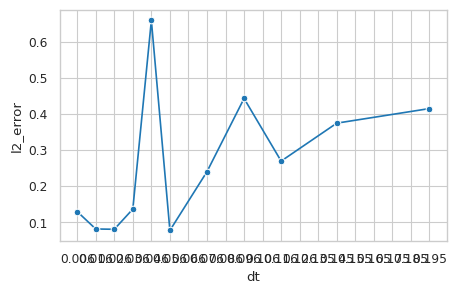

In [12]:
# plot the error
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=mean_error, x="dt", y="l2_error", ax=ax, marker="o")

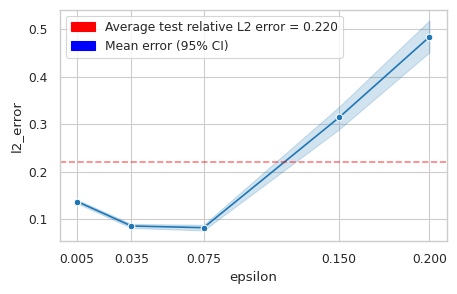

In [13]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=df, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(df["epsilon"].unique())

plt.axhline(y=ood_relative_l2, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {ood_relative_l2:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Mean error (95% CI)"),
    ]
)
plt.show()

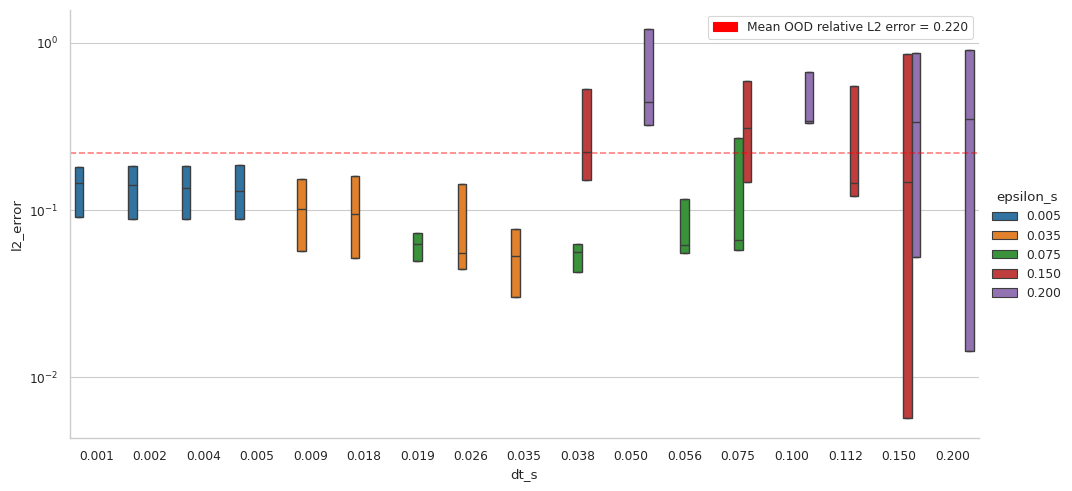

In [14]:
df["epsilon_s"] = df["epsilon"].apply(lambda x: f"{x:.3f}")
df["dt_s"] = df["dt"].apply(lambda x: f"{x:.3f}")

sns.catplot(
    data=df,
    x="dt_s",
    y="l2_error",
    log_scale=True,
    hue="epsilon_s",
    height=5,
    aspect=2,
    kind="box",
)
# draw a horizontal line at the OOD relative L2 error
plt.axhline(y=ood_relative_l2, color="r", linestyle="--", label="OOD relative L2 error", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Mean OOD relative L2 error = {ood_relative_l2:.3f}"),
    ]
)


In [15]:
time_pairs = [(0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/OOD_allen_cahn.npz", device=DEVICE
    )
)

print("Dataset length:", len(dataset))

BATCH_SIZE = 5
sampler = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset length: 7500


In [16]:
fno.eval()
progress_bar = tqdm.tqdm(sampler)

with torch.no_grad():
    ood_relative_l2 = 0.0
    for i, (dt, eps, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt, eps).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=-1)

        for j in range(len(dt)):
            errors["dt"].append(dt[j].item())
            errors["l2_error"].append(loss[j].item())
            errors["epsilon"].append(eps[j].item())

        ood_relative_l2 += loss.sum().item()

    ood_relative_l2 /= len(dataset)

print(rf"OOD relative L2 error (Only prediction t_0 -> t_1): {ood_relative_l2}")

  1%|          | 11/1500 [00:00<00:13, 108.41it/s]

100%|██████████| 1500/1500 [00:12<00:00, 117.68it/s]

OOD relative L2 error (Only prediction t_0 -> t_1): 0.11515763942102591


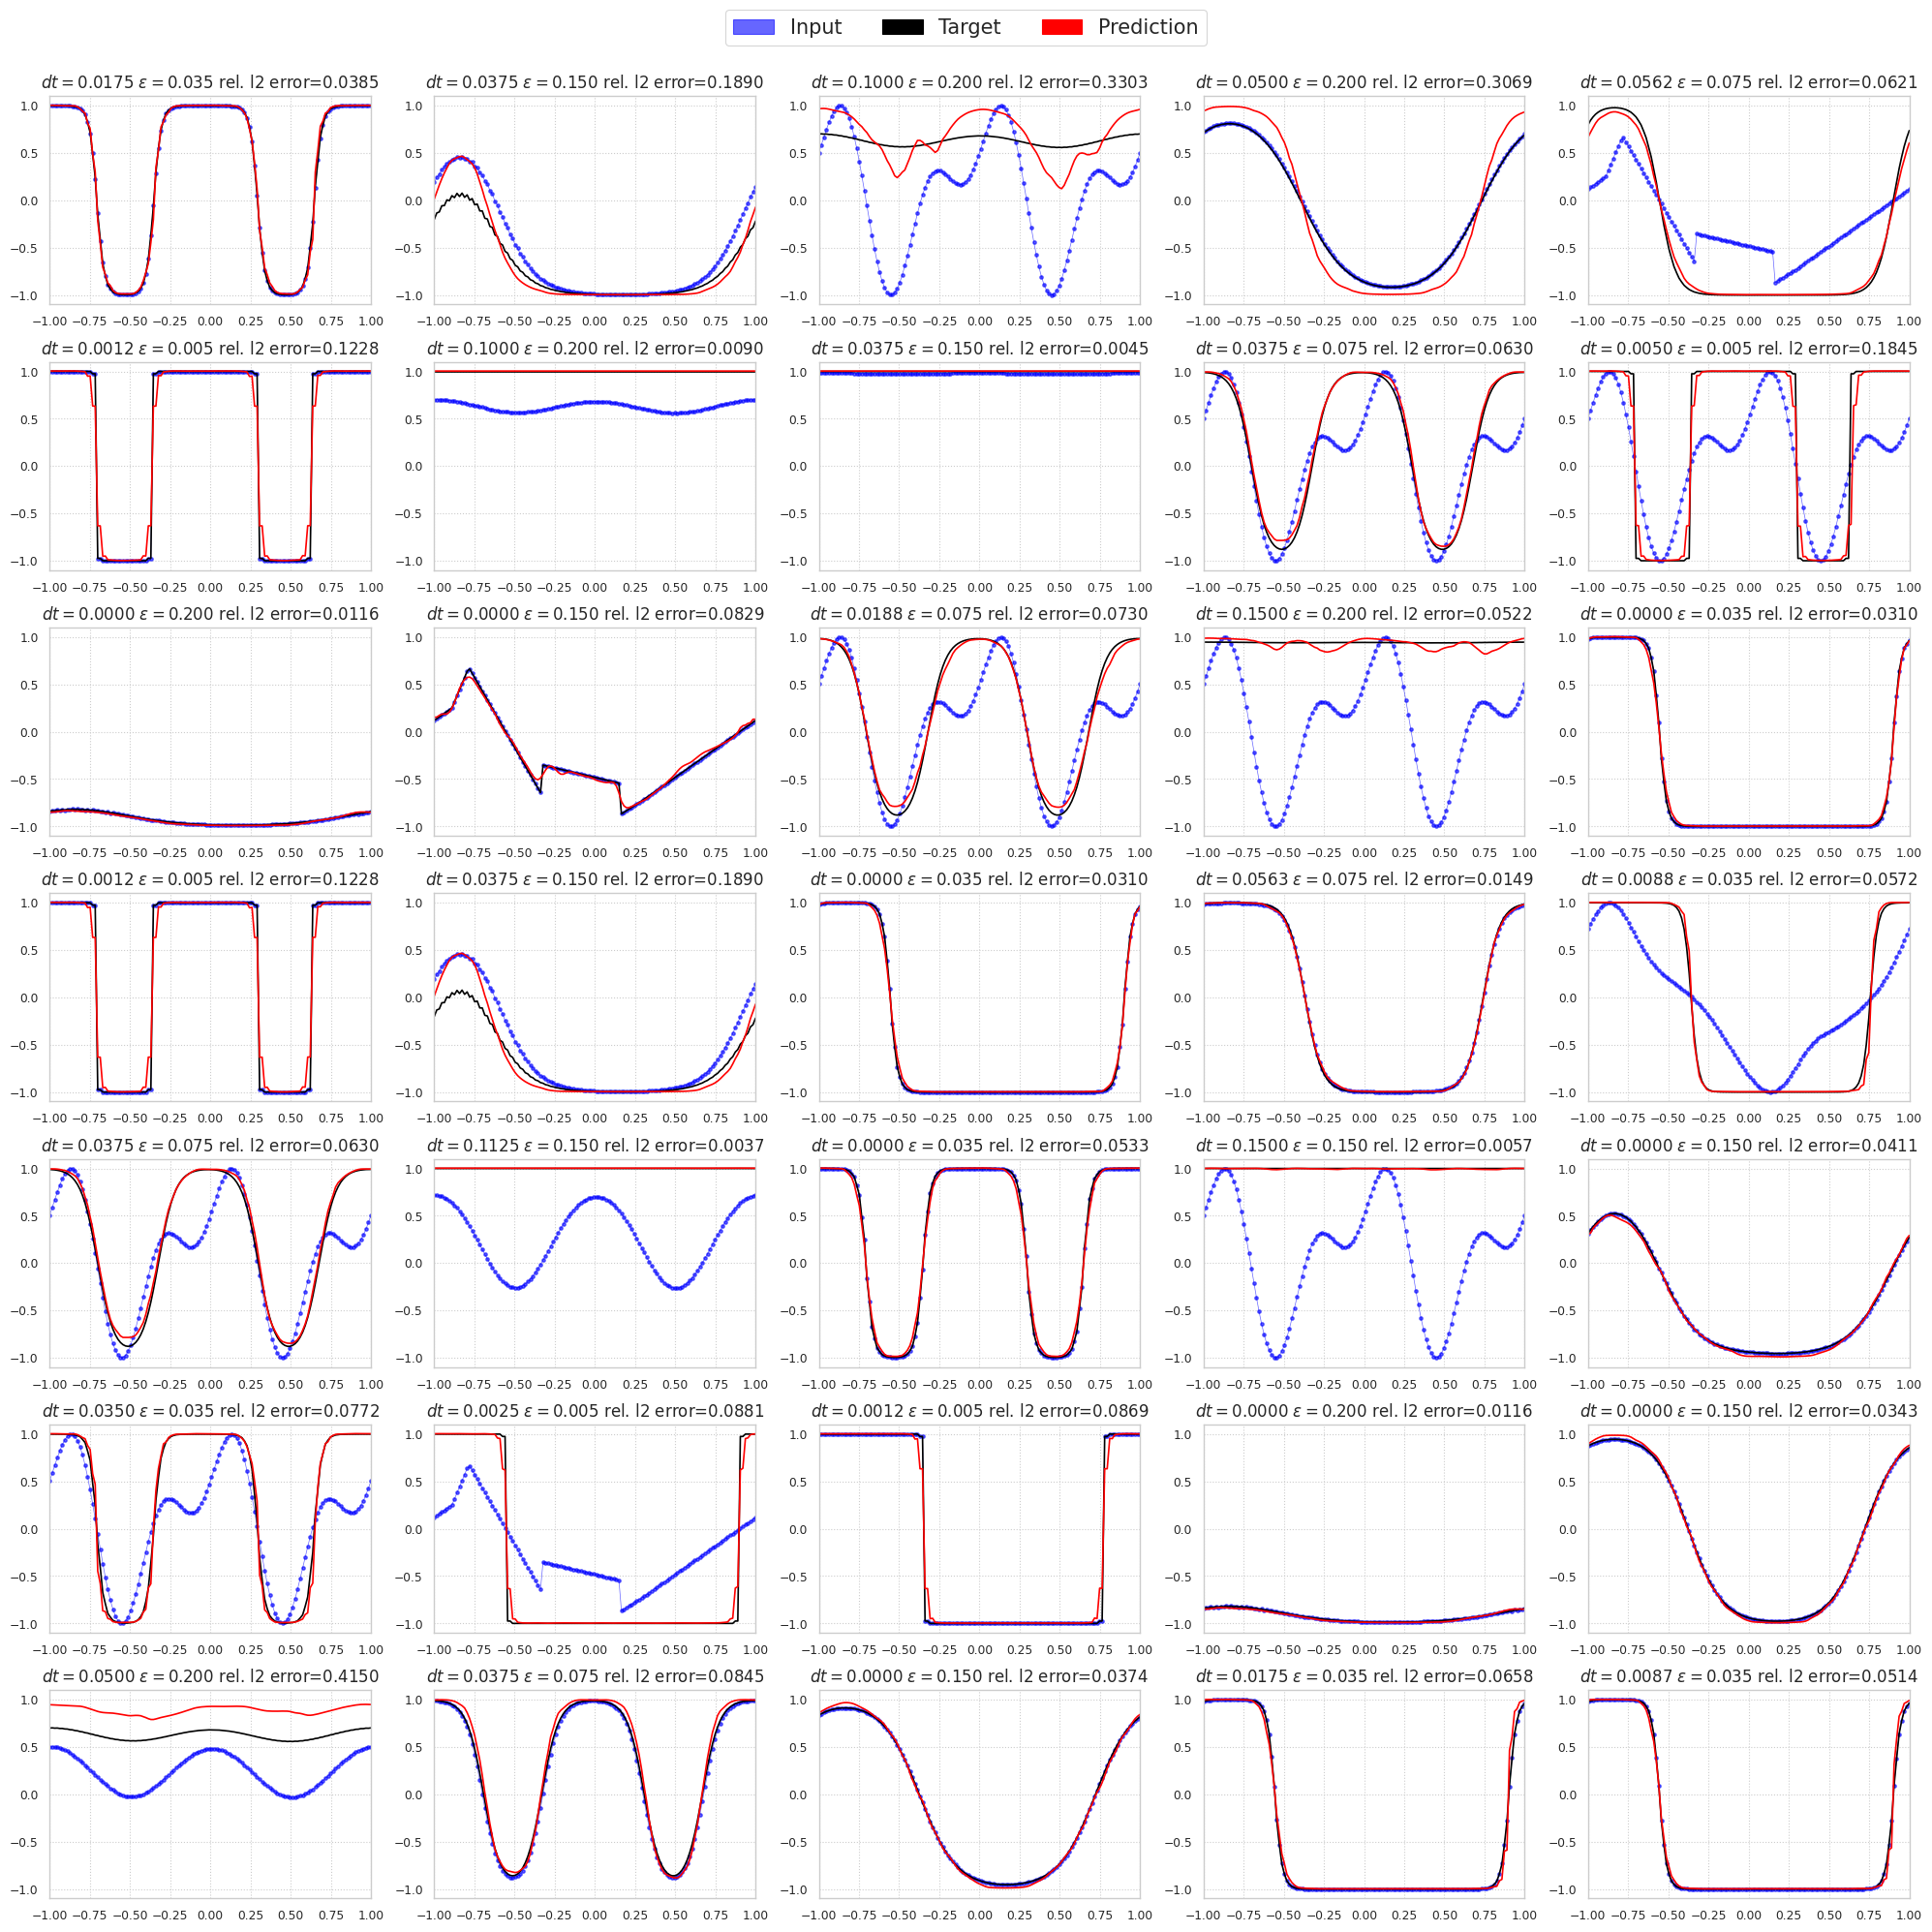

In [17]:
fig, axs = plt.subplots(7, BATCH_SIZE, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = eps[j].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]

        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.4f}$ $\epsilon={epsilon:.3f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.plot(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.6,
            linewidth=0.5,
            color="blue",
            marker="."
        )

        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = l1 + l2 + l3

labels = [line.get_label() for line in lines]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    colour = lines[group_idx].get_color()
    opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()